In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector,DensityMatrix,state_fidelity,partial_trace, Operator
from matplotlib import pyplot as plt
from functools import reduce
from scipy.linalg import expm
import pandas as pd

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

Hamiltonian:

$H=-h(X_1+X_2)-J Z_1 Z_2$

Trotter formula:

$e^{-iH t}=(e^{i h X_1 \Delta t}e^{i h X_2 \Delta t}e^{i J Z_1 Z_2 \Delta t})^{N_{\text{Trot}}},$

where $\Delta t=t/N_{\text{Trot}}$.

In [2]:
def tfim_circuit_with_noise_at_end(qc, n, m, J, h, t, p, epsilon):
    # Time increment for each Trotter step
    dt = t / p
    
    # Define the depolarizing error
    depolarizing = depolarizing_error(epsilon, 1)
    two_qubit_depolarizing = depolarizing_error(epsilon, 2)
    
    for step in range(p):
        # Apply the ZZ coupling terms with noise
        for i in range(n,m):
            qc.rzz(2 * -J * dt, i, i + 1)
        
        # Apply the transverse field terms with noise
        for i in range(n,m+1):
            qc.rx(2 * -h * dt, i)
    qc.append(two_qubit_depolarizing, [n, m])
    
    return qc

def tfim_circuit_with_gate_noise(qc, n, m, J, h, t, p, epsilon):
    # Time increment for each Trotter step
    dt = t / p
    
    # Define the depolarizing error
    depolarizing = depolarizing_error(epsilon, 1)
    two_qubit_depolarizing = depolarizing_error(epsilon, 2)
    
    for step in range(p):
        # Apply the ZZ coupling terms with noise
        for i in range(n,m):
            qc.rzz(2 * -J * dt, i, i + 1)
            qc.append(two_qubit_depolarizing, [i, i+1])
        
        # Apply the transverse field terms with noise
        for i in range(n,m+1):
            qc.rx(2 * -h * dt, i)
            qc.append(depolarizing, [i])
    
    return qc

def construct_hamiltonian(N, J, h):
    
    #definitions
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    identity = np.eye(2)
    
    H = np.zeros((2**N, 2**N))
    
    # Interaction term: -J * sum(sigma_z[i] * sigma_z[i+1])
    for i in range(N):
        for j in range(i+1, N):
            term = 1
            for k in range(N):
                if k == i:
                    term = np.kron(term, sigma_z)
                elif k == j:
                    term = np.kron(term, sigma_z)
                else:
                    term = np.kron(term, identity)
            H += -J * term

    # Transverse field term: -h * sum(sigma_x[i])
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = np.kron(term, sigma_x)
            else:
                term = np.kron(term, identity)
        H += -h * term

    return H

def getExactState(n_qubits, J, h, time):
    hamiltonian = construct_hamiltonian(n_qubits, J, h)

    # Exact time evolution using matrix exponentiation
    exact_operator = expm(-1j * time * hamiltonian)
    
    # Create an initial state (|00...0>)
    initial_state = np.zeros(2**n_qubits)
    initial_state[0] = 1
    
    # Apply exact time evolution
    pure_state = exact_operator @ initial_state
    pure_state = DensityMatrix(pure_state)

    return pure_state

# Input state without purification, used for benchmarking
     
def getInputRho(epsilon, t, N, gate_noise=0):

    # Create a Quantum Circuit acting on a quantum register of 2 qubits
    qc = QuantumCircuit(2)

    if gate_noise==0:
        qc=tfim_circuit_with_noise_at_end(qc, 0, 1, J, h, t, N, epsilon)
    else:
        qc=tfim_circuit_with_gate_noise(qc, 0, 1, J, h, t, N, epsilon)
        
    state = DensityMatrix(qc)

    return state

In [3]:
def getPurifiedRhoWithSWAP1213GHZ(epsilon,n,N,flag):

    list_rho_odd=[]
    list_rho_even=[]
    list_p00or11_odd=[]
    list_p00or11_even=[]
    list_p01or10_odd=[]
    list_p01or10_even=[]

    qc_odd = QuantumCircuit(8)
    qc_odd.reset(0)
    qc_odd.reset(1)
    
    # Apply the Hadamard gate to the first and second qubits
    qc_odd.h(0)
    qc_odd.cx(0,1)
    
    # Apply the first CSWAP gate controlled by q0, targeting q1 and q3
    qc_odd.cswap(0, 2, 4)
    
    # Apply the second CSWAP gate controlled by q0, targeting q2 and q4
    qc_odd.cswap(1, 3, 5)
    
    # Apply the second Hadamard gate to the first and second qubits
    qc_odd.h(0)
    qc_odd.h(1)

    qc_even = QuantumCircuit(8)
    qc_even.reset(0)
    qc_even.reset(1)
    # Apply the Hadamard gate to the first and second qubits
    qc_even.h(0)
    qc_even.cx(0,1)
    
    # Apply the first CSWAP gate controlled by q0, targeting q1 and q3
    qc_even.cswap(0, 2, 6)
    
    # Apply the second CSWAP gate controlled by q0, targeting q2 and q4
    qc_even.cswap(1, 3, 7)
    
    # Apply the second Hadamard gate to the first and second qubit
    qc_even.h(0)
    qc_even.h(1)

    # Create a Quantum Circuit acting on a quantum register of five qubits
    qc = QuantumCircuit(8)
    
    qc=tfim_circuit_with_noise_at_end(qc, 2, 3, J, h, t, N, epsilon)
    qc=tfim_circuit_with_noise_at_end(qc, 4, 5, J, h, t, N, epsilon)
    qc=tfim_circuit_with_noise_at_end(qc, 6, 7, J, h, t, N, epsilon)
    
    # Apply the Hadamard gate to the first and second qubits
    qc.h(0)
    qc.cx(0,1)
    
    # Apply the first CSWAP gate controlled by q0, targeting q1 and q3
    qc.cswap(0, 2, 4)
    
    # Apply the second CSWAP gate controlled by q0, targeting q2 and q4
    qc.cswap(1, 3, 5)
    
    # Apply the second Hadamard gate to the first and second qubits
    qc.h(0)
    qc.h(1)
    
    state = DensityMatrix(qc)

    # Define the |0><0| projection matrix for a single qubit
    P0 = np.array([[1, 0],
                   [0, 0]])
    P1 = np.array([[0, 0],
                   [0, 1]])
    
    # Define the 2x2 identity matrix
    I = np.eye(2)
    
    # Create the 8-qubit projection operator using tensor products
    projection_operator00 = Operator(I).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(P0)).tensor(Operator(P0))
    projection_operator01 = Operator(I).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(P1)).tensor(Operator(P0))
    projection_operator10 = Operator(I).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(P0)).tensor(Operator(P1))
    projection_operator11 = Operator(I).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(P1)).tensor(Operator(P1))
    
    projected_rho00=projection_operator00@state@projection_operator00.adjoint()
    prob_00=np.trace(projection_operator00@state@projection_operator00)
    post_meas_rho00=projected_rho00/prob_00
    
    projected_rho01=projection_operator01@state@projection_operator01.adjoint()
    prob_01=np.trace(projection_operator01@state@projection_operator01)
    post_meas_rho01=projected_rho01/prob_01

    projected_rho10=projection_operator10@state@projection_operator10.adjoint()
    prob_10=np.trace(projection_operator10@state@projection_operator10)
    post_meas_rho10=projected_rho10/prob_10

    projected_rho11=projection_operator11@state@projection_operator11.adjoint()
    prob_11=np.trace(projection_operator11@state@projection_operator11)
    post_meas_rho11=projected_rho11/prob_11

    list_p00or11_odd.append(prob_00+prob_11)
    list_p01or10_odd.append(prob_10+prob_01)
    
    # Trace out qubits q0, q1, q2, q3, q4 and q5
    list_rho_odd.append(partial_trace(DensityMatrix((projected_rho01+projected_rho10)/(prob_01+prob_10)), [0, 1, 2, 3, 4, 5]))
    # update the state
    state=DensityMatrix((projected_rho00+projected_rho11)/(prob_00+prob_11))
    
    state=state.evolve(qc_even)
    
    projected_rho00=projection_operator00@state@projection_operator00.adjoint()
    prob_00=np.trace(projection_operator00@state@projection_operator00)
    post_meas_rho00=projected_rho00/prob_00
    
    projected_rho01=projection_operator01@state@projection_operator01.adjoint()
    prob_01=np.trace(projection_operator01@state@projection_operator01)
    post_meas_rho01=projected_rho01/prob_01

    projected_rho10=projection_operator10@state@projection_operator10.adjoint()
    prob_10=np.trace(projection_operator10@state@projection_operator10)
    post_meas_rho10=projected_rho10/prob_10

    projected_rho11=projection_operator11@state@projection_operator11.adjoint()
    prob_11=np.trace(projection_operator11@state@projection_operator11)
    post_meas_rho11=projected_rho11/prob_11

    list_p00or11_even.append(prob_00+prob_11)
    list_p01or10_even.append(prob_10+prob_01)
    
    # Trace out qubits q0, q1, q2, q3, q6, and q7
    list_rho_even.append(partial_trace(DensityMatrix((projected_rho01+projected_rho10)/(prob_01+prob_10)), [0, 1, 2, 3, 6, 7]))
    
    # update the state
    state=DensityMatrix((projected_rho00+projected_rho11)/(prob_00+prob_11))
    
    for i in range(n-1):
            # Block A
            
            state=state.evolve(qc_odd)
        
            projected_rho00=projection_operator00@state@projection_operator00.adjoint()
            prob_00=np.trace(projection_operator00@state@projection_operator00)
            post_meas_rho00=projected_rho00/prob_00
    
            projected_rho01=projection_operator01@state@projection_operator01.adjoint()
            prob_01=np.trace(projection_operator01@state@projection_operator01)
            post_meas_rho01=projected_rho01/prob_01
        
            projected_rho10=projection_operator10@state@projection_operator10.adjoint()
            prob_10=np.trace(projection_operator10@state@projection_operator10)
            post_meas_rho10=projected_rho10/prob_10
        
            projected_rho11=projection_operator11@state@projection_operator11.adjoint()
            prob_11=np.trace(projection_operator11@state@projection_operator11)
            post_meas_rho11=projected_rho11/prob_11
        
            list_p00or11_odd.append(prob_00+prob_11)
            list_p01or10_odd.append(prob_10+prob_01)
            
            # Trace out qubits q0, q1, q2, q3, q4 and q5
            list_rho_odd.append(partial_trace(DensityMatrix((projected_rho01+projected_rho10)/(prob_01+prob_10)), [0, 1, 2, 3, 4, 5]))
            
            # update the state
            state=DensityMatrix((projected_rho00+projected_rho11)/(prob_00+prob_11))

            # Block B
            state=state.evolve(qc_even)
        
            projected_rho00=projection_operator00@state@projection_operator00.adjoint()
            prob_00=np.trace(projection_operator00@state@projection_operator00)
            post_meas_rho00=projected_rho00/prob_00
            
            projected_rho01=projection_operator01@state@projection_operator01.adjoint()
            prob_01=np.trace(projection_operator01@state@projection_operator01)
            post_meas_rho01=projected_rho01/prob_01
        
            projected_rho10=projection_operator10@state@projection_operator10.adjoint()
            prob_10=np.trace(projection_operator10@state@projection_operator10)
            post_meas_rho10=projected_rho10/prob_10
        
            projected_rho11=projection_operator11@state@projection_operator11.adjoint()
            prob_11=np.trace(projection_operator11@state@projection_operator11)
            post_meas_rho11=projected_rho11/prob_11
        
        
        
            list_p00or11_even.append(prob_00+prob_11)
            list_p01or10_even.append(prob_10+prob_01)
            
            
            # Trace out qubits q0, q1, q2, q3, q6, and q7
            list_rho_even.append(partial_trace(DensityMatrix((projected_rho01+projected_rho10)/(prob_01+prob_10)), [0, 1, 2, 3, 6, 7]))
        
            # update the state
            state=DensityMatrix((projected_rho00+projected_rho11)/(prob_00+prob_11))
        

    purified_rho=list_p01or10_odd[0]*list_rho_odd[0]
    purified_rho=purified_rho+list_p00or11_odd[0]*list_p01or10_even[0]*list_rho_even[0]
    
    for j in range(n-1):
        #print(j)
        product_list_p00or11_odd=reduce(lambda x, y: x * y, list_p00or11_odd[:j+1])
        product_list_p00or11_even=reduce(lambda x, y: x * y, list_p00or11_even[:j+1])
        product_list_p00or11=product_list_p00or11_odd*product_list_p00or11_even

        purified_rho=purified_rho+product_list_p00or11*list_p01or10_odd[j+1]*list_rho_odd[j+1]
        purified_rho=purified_rho+product_list_p00or11*list_p00or11_odd[j+1]*list_p01or10_even[j+1]*list_rho_even[j+1]

    product_list_p00or11_odd=reduce(lambda x, y: x * y, list_p00or11_odd[:n])
    product_list_p00or11_even=reduce(lambda x, y: x * y, list_p00or11_even[:n])
    product_list_p00or11=product_list_p00or11_odd*product_list_p00or11_even

    if flag > 0:
        purified_rho=partial_trace(state, [0, 1, 4, 5, 6, 7])
    else:
        purified_rho=purified_rho+product_list_p00or11*partial_trace(state, [0, 1, 2, 3, 4, 5])

    return DensityMatrix(purified_rho)

In [4]:
def getPurifiedRhoWithNoisySWAP1213GHZ(epsilon, t, J, h, N, n,flag,epsCircuit, gate_noise=0):

    list_rho_odd=[]
    list_rho_even=[]
    list_p00or11_odd=[]
    list_p00or11_even=[]
    list_p01or10_odd=[]
    list_p01or10_even=[]

    depolarizing = depolarizing_error(epsCircuit, 1)
    two_qubit_depolarizing = depolarizing_error(epsCircuit, 2)
    three_qubit_depolarizing = depolarizing_error(epsCircuit, 3)

    qc_odd = QuantumCircuit(8)
    qc_odd.reset(0)
    qc_odd.reset(1)
    
    # Apply the Hadamard gate to the first and second qubits
    qc_odd.h(0)
    qc_odd.append(depolarizing, [0])
    
    qc_odd.cx(0,1)
    qc_odd.append(two_qubit_depolarizing, [0, 1])
    
    # Apply the first CSWAP gate controlled by q0, targeting q1 and q3
    qc_odd.cswap(0, 2, 4)
    qc_odd.append(three_qubit_depolarizing, [0,2,4])
    
    # Apply the second CSWAP gate controlled by q0, targeting q2 and q4
    qc_odd.cswap(1, 3, 5)
    qc_odd.append(three_qubit_depolarizing, [1,3,5])
    
    # Apply the second Hadamard gate to the first and second qubits
    qc_odd.h(0)
    qc_odd.append(depolarizing, [0])
    
    qc_odd.h(1)
    qc_odd.append(depolarizing, [1])

    qc_even = QuantumCircuit(8)
    qc_even.reset(0)
    qc_even.reset(1)
    
    # Apply the Hadamard gate to the first and second qubits
    qc_even.h(0)
    qc_even.append(depolarizing, [0])
    
    qc_even.cx(0,1)
    qc_even.append(two_qubit_depolarizing, [0, 1])
    
    # Apply the first CSWAP gate controlled by q0, targeting q1 and q3
    qc_even.cswap(0, 2, 6)
    qc_even.append(three_qubit_depolarizing, [0,2,6])
    
    # Apply the second CSWAP gate controlled by q0, targeting q2 and q4
    qc_even.cswap(1, 3, 7)
    qc_even.append(three_qubit_depolarizing, [1,3,7])
    
    # Apply the second Hadamard gate to the first and second qubit
    qc_even.h(0)
    qc_even.append(depolarizing, [0])
    
    qc_even.h(1)
    qc_even.append(depolarizing, [1])

    # Create a Quantum Circuit acting on a quantum register of five qubits
    qc = QuantumCircuit(8)

    if gate_noise==0:
        qc=tfim_circuit_with_noise_at_end(qc, 2, 3, J, h, t, N, epsilon)
        qc=tfim_circuit_with_noise_at_end(qc, 4, 5, J, h, t, N, epsilon)
        qc=tfim_circuit_with_noise_at_end(qc, 6, 7, J, h, t, N, epsilon)
    else:
        qc=tfim_circuit_with_gate_noise(qc, 2, 3, J, h, t, N, epsilon)
        qc=tfim_circuit_with_gate_noise(qc, 4, 5, J, h, t, N, epsilon)
        qc=tfim_circuit_with_gate_noise(qc, 6, 7, J, h, t, N, epsilon)
    
    # Apply the Hadamard gate to the first and second qubits
    qc.h(0)
    qc.append(depolarizing, [0])
    
    qc.cx(0,1)
    qc.append(two_qubit_depolarizing, [0, 1])
    
    # Apply the first CSWAP gate controlled by q0, targeting q1 and q3
    qc.cswap(0, 2, 4)
    qc.append(three_qubit_depolarizing, [0,2,4])
    
    # Apply the second CSWAP gate controlled by q0, targeting q2 and q4
    qc.cswap(1, 3, 5)
    qc.append(three_qubit_depolarizing, [1,3,5])
    
    # Apply the second Hadamard gate to the first and second qubits
    qc.h(0)
    qc.append(depolarizing, [0])
    
    qc.h(1)
    qc.append(depolarizing, [1])
    
    state = DensityMatrix(qc)

    # Define the |0><0| projection matrix for a single qubit
    P0 = np.array([[1, 0],
                   [0, 0]])
    P1 = np.array([[0, 0],
                   [0, 1]])
    
    # Define the 2x2 identity matrix
    I = np.eye(2)
    
    # Create the 8-qubit projection operator using tensor products
    projection_operator00 = Operator(I).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(P0)).tensor(Operator(P0))
    projection_operator01 = Operator(I).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(P1)).tensor(Operator(P0))
    projection_operator10 = Operator(I).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(P0)).tensor(Operator(P1))
    projection_operator11 = Operator(I).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(I)).tensor(Operator(P1)).tensor(Operator(P1))
    
    projected_rho00=projection_operator00@state@projection_operator00.adjoint()
    prob_00=np.trace(projection_operator00@state@projection_operator00)
    post_meas_rho00=projected_rho00/prob_00
    
    projected_rho01=projection_operator01@state@projection_operator01.adjoint()
    prob_01=np.trace(projection_operator01@state@projection_operator01)
    post_meas_rho01=projected_rho01/prob_01

    projected_rho10=projection_operator10@state@projection_operator10.adjoint()
    prob_10=np.trace(projection_operator10@state@projection_operator10)
    post_meas_rho10=projected_rho10/prob_10

    projected_rho11=projection_operator11@state@projection_operator11.adjoint()
    prob_11=np.trace(projection_operator11@state@projection_operator11)
    post_meas_rho11=projected_rho11/prob_11

    list_p00or11_odd.append(prob_00+prob_11)
    list_p01or10_odd.append(prob_10+prob_01)
    
    # Trace out qubits q0, q1, q2, q3, q4 and q5
    list_rho_odd.append(partial_trace(DensityMatrix((projected_rho01+projected_rho10)/(prob_01+prob_10)), [0, 1, 2, 3, 4, 5]))
    # update the state
    state=DensityMatrix((projected_rho00+projected_rho11)/(prob_00+prob_11))
    
    state=state.evolve(qc_even)
    
    projected_rho00=projection_operator00@state@projection_operator00.adjoint()
    prob_00=np.trace(projection_operator00@state@projection_operator00)
    post_meas_rho00=projected_rho00/prob_00
    
    projected_rho01=projection_operator01@state@projection_operator01.adjoint()
    prob_01=np.trace(projection_operator01@state@projection_operator01)
    post_meas_rho01=projected_rho01/prob_01

    projected_rho10=projection_operator10@state@projection_operator10.adjoint()
    prob_10=np.trace(projection_operator10@state@projection_operator10)
    post_meas_rho10=projected_rho10/prob_10

    projected_rho11=projection_operator11@state@projection_operator11.adjoint()
    prob_11=np.trace(projection_operator11@state@projection_operator11)
    post_meas_rho11=projected_rho11/prob_11

    list_p00or11_even.append(prob_00+prob_11)
    list_p01or10_even.append(prob_10+prob_01)
    
    # Trace out qubits q0, q1, q2, q3, q6, and q7
    list_rho_even.append(partial_trace(DensityMatrix((projected_rho01+projected_rho10)/(prob_01+prob_10)), [0, 1, 2, 3, 6, 7]))
    
    # update the state
    state=DensityMatrix((projected_rho00+projected_rho11)/(prob_00+prob_11))
    
    for i in range(n-1):
            # Block A
            
            state=state.evolve(qc_odd)
        
            projected_rho00=projection_operator00@state@projection_operator00.adjoint()
            prob_00=np.trace(projection_operator00@state@projection_operator00)
            post_meas_rho00=projected_rho00/prob_00
    
            projected_rho01=projection_operator01@state@projection_operator01.adjoint()
            prob_01=np.trace(projection_operator01@state@projection_operator01)
            post_meas_rho01=projected_rho01/prob_01
        
            projected_rho10=projection_operator10@state@projection_operator10.adjoint()
            prob_10=np.trace(projection_operator10@state@projection_operator10)
            post_meas_rho10=projected_rho10/prob_10
        
            projected_rho11=projection_operator11@state@projection_operator11.adjoint()
            prob_11=np.trace(projection_operator11@state@projection_operator11)
            post_meas_rho11=projected_rho11/prob_11
        
            list_p00or11_odd.append(prob_00+prob_11)
            list_p01or10_odd.append(prob_10+prob_01)
            
            # Trace out qubits q0, q1, q2, q3, q4 and q5
            list_rho_odd.append(partial_trace(DensityMatrix((projected_rho01+projected_rho10)/(prob_01+prob_10)), [0, 1, 2, 3, 4, 5]))
            
            # update the state
            state=DensityMatrix((projected_rho00+projected_rho11)/(prob_00+prob_11))

            # Block B
            state=state.evolve(qc_even)
        
            projected_rho00=projection_operator00@state@projection_operator00.adjoint()
            prob_00=np.trace(projection_operator00@state@projection_operator00)
            post_meas_rho00=projected_rho00/prob_00
            
            projected_rho01=projection_operator01@state@projection_operator01.adjoint()
            prob_01=np.trace(projection_operator01@state@projection_operator01)
            post_meas_rho01=projected_rho01/prob_01
        
            projected_rho10=projection_operator10@state@projection_operator10.adjoint()
            prob_10=np.trace(projection_operator10@state@projection_operator10)
            post_meas_rho10=projected_rho10/prob_10
        
            projected_rho11=projection_operator11@state@projection_operator11.adjoint()
            prob_11=np.trace(projection_operator11@state@projection_operator11)
            post_meas_rho11=projected_rho11/prob_11
        
            list_p00or11_even.append(prob_00+prob_11)
            list_p01or10_even.append(prob_10+prob_01)
            
            # Trace out qubits q0, q1, q2, q3, q6, and q7
            list_rho_even.append(partial_trace(DensityMatrix((projected_rho01+projected_rho10)/(prob_01+prob_10)), [0, 1, 2, 3, 6, 7]))
        
            # update the state
            state=DensityMatrix((projected_rho00+projected_rho11)/(prob_00+prob_11))
        
    purified_rho=list_p01or10_odd[0]*list_rho_odd[0]
    purified_rho=purified_rho+list_p00or11_odd[0]*list_p01or10_even[0]*list_rho_even[0]
    
    for j in range(n-1):
        #print(j)
        product_list_p00or11_odd=reduce(lambda x, y: x * y, list_p00or11_odd[:j+1])
        product_list_p00or11_even=reduce(lambda x, y: x * y, list_p00or11_even[:j+1])
        product_list_p00or11=product_list_p00or11_odd*product_list_p00or11_even

        purified_rho=purified_rho+product_list_p00or11*list_p01or10_odd[j+1]*list_rho_odd[j+1]
        purified_rho=purified_rho+product_list_p00or11*list_p00or11_odd[j+1]*list_p01or10_even[j+1]*list_rho_even[j+1]

    product_list_p00or11_odd=reduce(lambda x, y: x * y, list_p00or11_odd[:n])
    product_list_p00or11_even=reduce(lambda x, y: x * y, list_p00or11_even[:n])
    product_list_p00or11=product_list_p00or11_odd*product_list_p00or11_even

    if flag > 0:
        purified_rho=partial_trace(state, [0, 1, 4, 5, 6, 7])
    else:
        purified_rho=purified_rho+product_list_p00or11*partial_trace(state, [0, 1, 2, 3, 4, 5])
      
    return DensityMatrix(purified_rho) 

In [5]:
#Simultation code
t=1
J=1
h=1
N=10
list_of_epsilon=[i * 0.05 for i in range(21)]
list_of_purified_fidelity_flag0=[]
list_of_purified_fidelity_flag0_n1=[]
list_of_purified_fidelity_flag0_n2=[]
list_of_purified_fidelity_theory=[]
list_of_fidelity=[]

pure_state =getExactState(2, J, h, t)

for i in list_of_epsilon:
    list_of_purified_fidelity_flag0_n1.append(state_fidelity(getPurifiedRhoWithSWAP1213GHZ(i,1,N,0), pure_state))
    list_of_purified_fidelity_flag0_n2.append(state_fidelity(getPurifiedRhoWithSWAP1213GHZ(i,2,N,0), pure_state))
    list_of_purified_fidelity_flag0.append(state_fidelity(getPurifiedRhoWithSWAP1213GHZ(i,10,N,0), pure_state))
    list_of_purified_fidelity_theory.append(1/8*(-2+i)*(1+i)*(-4+3*i))
    list_of_fidelity.append(state_fidelity(getInputRho(i, t, N), pure_state))

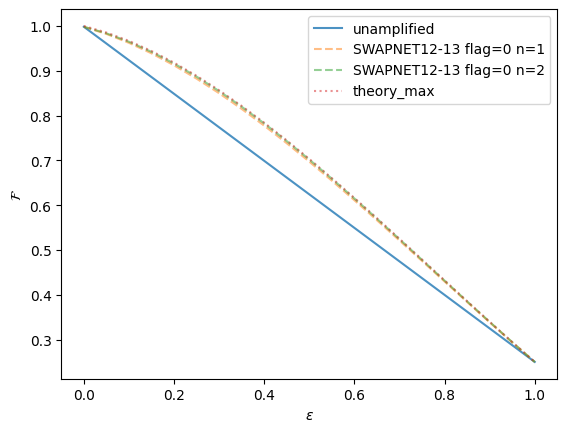

In [6]:
plt.plot(list_of_epsilon,list_of_fidelity,label='unamplified', alpha=0.8)
plt.plot(list_of_epsilon,list_of_purified_fidelity_flag0_n1,label='SWAPNET12-13 flag=0 n='+str(1), alpha=0.5, linestyle='dashed')
plt.plot(list_of_epsilon,list_of_purified_fidelity_flag0_n2,label='SWAPNET12-13 flag=0 n='+str(2), alpha=0.5, linestyle='dashed')
plt.plot(list_of_epsilon,list_of_purified_fidelity_theory,label='theory_max', alpha=0.5, linestyle='dotted')
   
plt.xlabel("$\\epsilon$")
plt.ylabel("$\\mathcal{F}$")
plt.legend()

In [7]:
#Simultation code
list_of_epsilon=[i * 0.005 for i in range(21)]
t=1
J=1
h=1
N=5
list_of_purified_fidelity_flag0_n1_noisy=[[] for _ in range(N)]
list_of_purified_fidelity_flag0_n2_noisy=[[] for _ in range(N)]
list_of_fidelity=[[] for _ in range(N)]

pure_state =getExactState(2, J, h, t)

for j in range(N):
    for i in list_of_epsilon:
        list_of_purified_fidelity_flag0_n1_noisy[j].append(state_fidelity(getPurifiedRhoWithNoisySWAP1213GHZ(i,t, J, h, j+1,1,0,i,1), pure_state))
        list_of_purified_fidelity_flag0_n2_noisy[j].append(state_fidelity(getPurifiedRhoWithNoisySWAP1213GHZ(i,t, J, h, j+1,2,0,i,1), pure_state))
        list_of_fidelity[j].append(state_fidelity(getInputRho(i,t,j+1,1), pure_state))

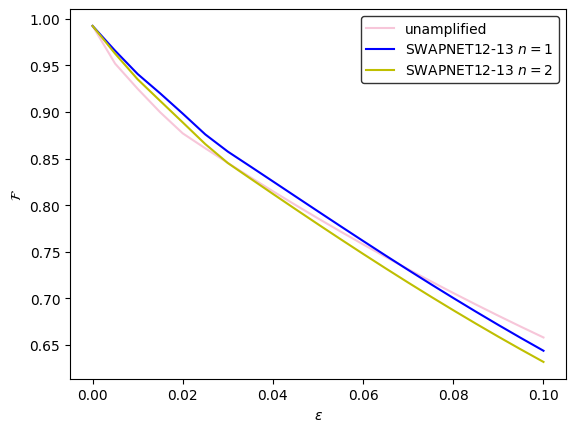

In [8]:
plt.rcParams['text.usetex']=False

max_list_of_fidelity=np.max(np.array(list_of_fidelity), axis=0)
max_list_of_purified_fidelity_flag0_n1_noisy=np.max(np.array(list_of_purified_fidelity_flag0_n1_noisy), axis=0)
max_list_of_purified_fidelity_flag0_n2_noisy=np.max(np.array(list_of_purified_fidelity_flag0_n2_noisy), axis=0)

plt.plot(list_of_epsilon,max_list_of_fidelity,label='unamplified', color='#F7C6D9')
plt.plot(list_of_epsilon,max_list_of_purified_fidelity_flag0_n1_noisy,label='SWAPNET12-13 $n=1$', color = 'b')
plt.plot(list_of_epsilon,max_list_of_purified_fidelity_flag0_n2_noisy,label='SWAPNET12-13 $n=2$', color = 'y')
    
plt.xlabel("$\\epsilon$")
plt.ylabel("$\\mathcal{F}$")
plt.legend(loc='upper right',edgecolor = 'black')